In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import glob
from imageio import imread

from hugeica import *

from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score

import re
from skimage.transform import resize

from data.mvtec import *

np.random.seed(252525)
torch.manual_seed(252525)


In [5]:
log_full = []
for clazz in range(8, len(MVTEC.CLASSES)):

    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)
    
    X_ = X_[np.random.permutation(75)] if len(X_) > 75 else X_
   
    hyp2 = SFA.hyperparameter_search(X_, X_valid_, X_test_,
                      patch_size=range(14, 15*14, 28),
                      n_components=["q95"], 
                      stride=[14], 
                      shape=(3, 224, 224), 
                      bs=15000, 
                      lr=1e-4,
                      epochs=20,
                      norm=[2],
                      mode="ta",
                      max_components=85,
                      min_components=10,
                      remove_components=[0],
                      use_conv=False,
                      logging=-1, 
                      aucs=["mean"],
                      compute_bpd=False) 
    log_full.append(hyp2)
    print(clazz)
        
#concat = pd.concat(log_full)
#concat["class"] = np.repeat(np.arange(len(log_full)), len(log_full[0]))
#concat.to_csv(f"./experiments/mvtec_hyperparameter_search_q90_ta.csv")

# Fit SpatialICA(q95).
# Fit HugeICA((29696, 588, 85), device='cuda', bs=14848)
# Re-Fit SpatialICA(10).
# Fit HugeICA((29696, 588, 10), device='cuda', bs=14848)
# Compute ICA metrics.
# Fit SFA(10).
# Compute information measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((11760, 5292, 85), device='cuda', bs=14896)
# Re-Fit SpatialICA(11).
# Fit HugeICA((11760, 5292, 11), device='cuda', bs=14896)
# Compute ICA metrics.
# Fit SFA(11).
# Compute information measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((8640, 14700, 85), device='cuda', bs=14976)
# Re-Fit SpatialICA(17).
# Fit HugeICA((8640, 14700, 17), device='cuda', bs=14976)
# Compute ICA metrics.
# Fit SFA(17).
# Compute information measures
# Compute AUCs
# Compute Spread
# Compute Entropy
# Fit SpatialICA(q95).
# Fit HugeICA((6000, 28812, 85), device='cuda', bs=15000)
# Re-Fit SpatialICA(19).
# Fit HugeICA((6000, 28812, 19), device='cuda',

In [62]:
log = pd.read_csv("./experiments/mvtec_hyperparameter_search_q90_ta_full.csv")

df = []
for i in range(15):
    l = log[log["class"] == i]
    l = l[l["nor"] == 2]
    df.append((l.sort_values("negH_sum", ascending=False)["mean"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["n_components"].head(1).item(),
              l.sort_values("negH_sum", ascending=False)["negH_sum"].head(1).item()))

display(pd.DataFrame(df, columns=["score", "patch_size", "k", "-H"] ))
pd.DataFrame([np.asarray(df).mean(0)[0]], columns=["mean score"] )


,score,patch_size,k,-H
0,0.699206,98.0,73.0,0.240807
1,0.532504,154.0,56.0,0.267329
2,0.586045,182.0,48.0,0.268433
3,0.557010,182.0,56.0,0.176369
4,0.635417,182.0,70.0,0.391641
5,0.915790,182.0,69.0,0.748121
6,0.752062,126.0,57.0,0.183001
7,0.466874,14.0,80.0,0.255460
8,0.561111,126.0,20.0,0.094842
9,0.601891,182.0,80.0,0.253723


,mean score
0,0.609087


In [109]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(5, P=224, s=224)

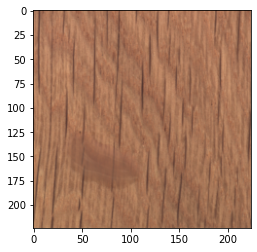

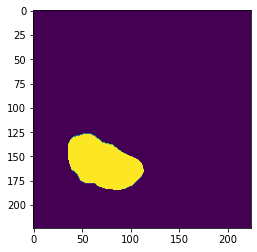

In [110]:
idx = np.random.randint(len(X_test_))
plt.imshow(X_test_[idx].transpose(1,2,0))
plt.show()
plt.imshow(X_labels_[idx].transpose(1,2,0))

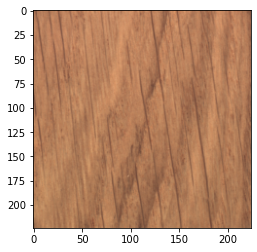

In [111]:
idx = np.random.randint(len(X_valid_))
plt.imshow(X_valid_[idx].transpose(1,2,0))

In [3]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(1, P=56, s=56, label_per_patch=False)

X_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_)

model = SFA(shape=(3, 56, 56), 
                BSZ=(28, 28), 
                stride=14, 
                n_components="q90",
                remove_components=0,
                max_components=85,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
model.fit(X_, 20, bs=15000, lr=1e-4, logging=-1)

KeyboardInterrupt: 

In [41]:
S_in = np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1).reshape(-1, 16).mean(1)
S_out = np.linalg.norm(  model.transform(np.asarray(X_out_), agg="mean"), axis=1).reshape(-1, 16).mean(1)
        
roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([S_in, S_out]))

0.3776083467094703

In [8]:
X_.shape, X_in_.shape

((245, 3, 224, 224), (32, 3, 224, 224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


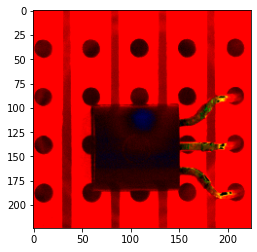

In [56]:
plt.imshow(X_out_[10].transpose(1,2,0))

In [3]:
def extend_model_(model, n_components, force=False):
    
    if hasattr(model, "extended_components") and not force:
        print("Model already extended with n_components =", model.extended_components)
        return
    
    W = model.model.net.whiten.weight.data
    dev = W.device
    
    model.model.n_components = model.model.n_components + n_components
    model.model.net.whiten.weight.data = torch.cat([model.model.net.whiten.weight.data, torch.ones((n_components, W.shape[1]))]).to(dev)
    model.model.net.whiten.var_expl.data = torch.cat([model.model.net.whiten.var_expl.data, torch.ones(n_components)]).to(dev)
    model.model.net.ica.weight.data = torch.eye(W.shape[0] + n_components).to(dev)
    
    model.extended_components = n_components


def patch_model_(model, X_ref, x, n_components=3):
    
    k = len(model.model.net.whiten.var_expl.data)
    model.model.net.whiten.var_expl.data[-n_components:] = torch.ones(n_components)
    
    model2 = SFA(shape=model.shape, 
                BSZ=model.BSZ, 
                stride=model.stride, 
                n_components=25,
                remove_components=0,
                max_components=25,
                min_components=2,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
    model2.fit(x, 1, bs=15000, lr=1e-4, logging=-1)
    
    W_new = model2.model.net.whiten.weight.data
    
    model.model.net.whiten.weight.data[-n_components:, :] = W_new[:n_components, :]
    batch = model.transform(np.asarray(X_ref), agg="none").reshape(-1, k)
    variance = batch.var(0)
    model.model.net.whiten.var_expl.data[-n_components:] = torch.from_numpy(variance[-n_components:])

    
def extended_scores(model, X_ref, X_test, n_components=3):
    
    extend_model_(model, n_components)
    
    scores = []
    
    for i in range(len(X_test)):
        
        x = X_test[i:i+1]
        
        patch_model_(model, X_ref, x, n_components)
        score = model.transform(np.asarray(x), agg="mean").flatten()
        scores.append(score)
        
    return np.asarray(scores)
        
    

In [115]:
extend_model_(model, 10, force=True)

In [ ]:
%%capture
S_in = extended_scores(model, X_ref_, X_in_, n_components=20)
S_out = extended_scores(model, X_ref_, X_out_, n_components=20)

In [ ]:
auc = roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([np.linalg.norm(S_in, axis=1, ord=2), np.linalg.norm(S_out, axis=1, ord=2)]))

S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).mean(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).mean(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(-4, 4)
plt.legend()
plt.title(f"MVTEC - Features mean")
plt.show()


S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).var(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).var(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(0, 4)
plt.legend()
plt.title(f"MVTEC - Features Variance")
plt.show()

print("auc", auc)

In [3]:
def preprocess(X, X_in, X_out, norm_contrast=True, DC=True, channels=None):
    
    X = X.copy()
    X_in = X_in.copy()
    X_out = X_out.copy()
    
    #DEQUANTIZE
    #X_, _ = dequantize(X)
    X_ = X
    
    # CONTRAST
    if norm_contrast:
        X_, _ = to_norm_contrast(X_, DC=DC, channels=channels)
    mean, std = np.zeros(X_.mean(0).shape), X_.std()
    mean, std = X_.mean(), X_.std()

    # SCALE
    X_, _ = scale(X_, mean, std)
    
    #X_in_, _ = dequantize(X_in)
    X_in_ = X_in
    if norm_contrast:
        X_in_, _ = to_norm_contrast(X_in_, DC=DC, channels=channels)
    
    #mean, std = np.zeros(X_in_.mean(0).shape), X_in_.std()
    # mean, std = X_in_.mean(), X_in_.std()
    X_in_, _ = scale(X_in_, mean, std)

    #X_out_, _ = dequantize(X_out)
    X_out_ = X_out
    
    if norm_contrast:
        X_out_, _ = to_norm_contrast(X_out_, DC=DC, channels=channels)
    # mean, std = np.zeros(X_out_.mean(0).shape), X_out_.std()
    # mean, std = X_out_.mean(), X_out_.std()
    X_out_, _ = scale(X_out_, mean, std)
    return X_, X_in_, X_out_, mean, std

# Fit SpatialICA(q95).
# Fit HugeICA((675, 132300, 75), device='cuda', bs=14994)
  0%|                                                                                                                                                                                                                                   | 0/1 [00:01<?, ?it/s]
Ep.  0 - -1.0101 - validation (loss/white/kurt/mi/logp): -0.9378 / 0.00 / 0.76 / 0.0194 / 0.4039 (eval took: 0.0s)
# Re-Fit SpatialICA(56).
# Fit HugeICA((675, 132300, 56), device='cuda', bs=14994)
  0%|                                                                                                                                                                                                                                   | 0/1 [00:01<?, ?it/s]
Ep.  0 - -1.0101 - validation (loss/white/kurt/mi/logp): -0.9379 / 0.00 / 0.93 / 0.0192 / 0.4012 (eval took: 0.0s)
Ep.  1 - -0.9379 - validation (loss/white/kurt/mi/logp): -0.9380 / 0.00 / 0.94 / 0.0195 / 0.4012

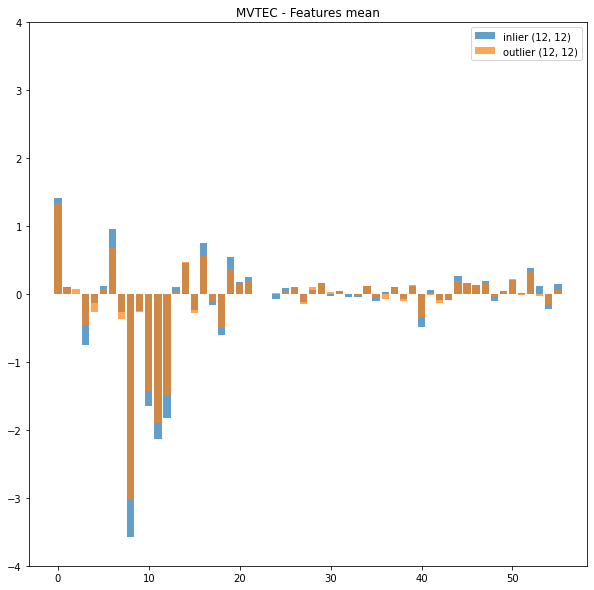

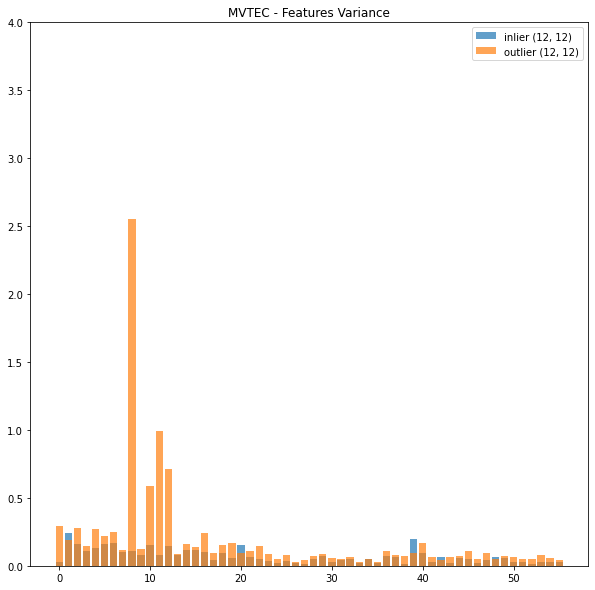

auc 0.5393258426966292 0.27141413


In [19]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(1, P=224, s=224, label_per_patch=False)
X_ref_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_, norm_contrast=True, DC=True, channels=None)

X_ref_ = X_ref_[:75]

m = 15 
t = 1 
model = SFA(shape=(3, 224, 224), 
                BSZ=(m*14, m*14), 
                stride=t*7, 
                n_components="q95",
                remove_components=0,
                max_components=75,
                min_components=10,
                mode="ta",
                use_conv=False,
                inter_image_diffs=False,
                extended_entropies=False)
model.fit(X_ref_, 20, bs=15000, lr=1e-4, logging=1)


# X_in_ = X_ref_[:32]

S_in = model.transform(np.asarray(X_in_), agg="mean")
S_out = model.transform(np.asarray(X_out_), agg="mean")
        
auc = roc_auc_score([0] * len(S_in) + [1] * len(S_out), np.concatenate([np.linalg.norm(S_in, axis=1, ord=2), np.linalg.norm(S_out, axis=1, ord=2)]))

S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).mean(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).mean(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(-4, 4)
plt.legend()
plt.title(f"MVTEC - Features mean")
plt.show()


S0 = model.transform(np.asarray(X_in_), agg="none", act = lambda x: x)
S0_ = model.transform(np.asarray(X_out_), agg="none", act = lambda x: x)

plt.bar(range(S0.shape[2]), S0.mean(1).var(0), label="inlier (12, 12)", alpha=0.7)
plt.bar(range(S0.shape[2]), S0_.mean(1).var(0), label="outlier (12, 12)", alpha=0.7 )
plt.ylim(0, 4)
plt.legend()
plt.title(f"MVTEC - Features Variance")
plt.show()

print("auc", auc, model.negH_sum)
# matplotlib2tikz.save(f"CIFAR_{class_name}_mean.tex")

In [70]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(14, P=224, s=224, label_per_patch=False)

X_.mean(), X_valid_.mean(), X_test_.mean(), X_.std(), X_valid_.std(), X_test_.std()

(0.3014042, 0.30240893, 0.3108688, 0.16926125, 0.17429799, 0.17344373)

In [81]:
X_ref_, X_in_, X_out_, mean, std = preprocess(X_, X_valid_, X_test_, norm_contrast=True, DC=True, channels=None)

X_ref_.mean(), X_in_.mean(), X_out_.mean()

(1.720884e-09, 5.406317e-09, -3.4059797e-09)

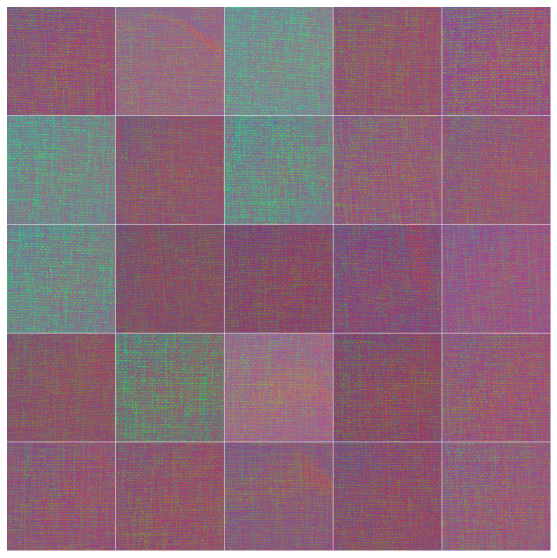

In [20]:
plt.rcParams["figure.figsize"] = (10, 10)

show_filters_color(X_ref_[:len(X_in_)].reshape(len(X_in_), -1).T, C=3)

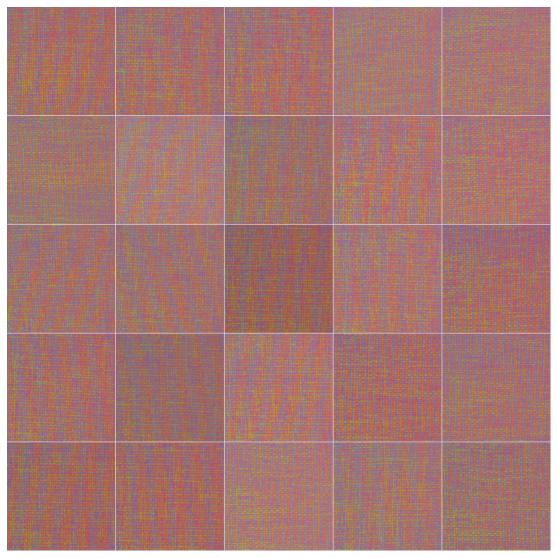

In [21]:
outlier_order = np.argsort(np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1))[::-1]
show_filters_color(X_in_[outlier_order].reshape(len(outlier_order), -1).T, C=3)

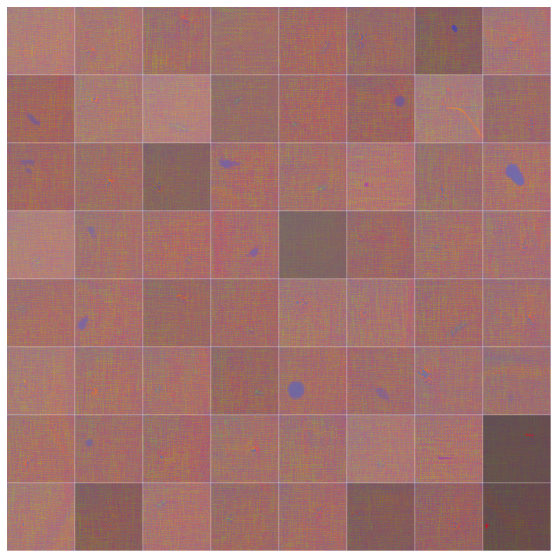

In [23]:
fpr = 100

scores_inlier = np.linalg.norm( model.transform(np.asarray(X_in_), agg="mean") , axis=1)
thresh = np.percentile(scores_inlier, 100 - fpr)

scores = np.linalg.norm( model.transform(np.asarray(X_out_), agg="mean") , axis=1)
outlier_order = np.argsort(scores)[::-1]
subset = X_out_[outlier_order]
scores = scores[outlier_order]

subset = subset[scores > thresh]

subset = subset.reshape(len(subset), -1)
show_filters_color(subset.T, C=3)

In [9]:
X_out_.shape

(40, 3, 224, 224)

In [ ]:
Intra-Klassenvarianz -> Var[Phi] hoch

Intra-Bildvarianz -> -> Var[Phi] hoch